In [1]:
## USE for Multi GPU Systems
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow as tf

%matplotlib inline

# Importing SK-learn to calculate precision and recall
import sklearn
from sklearn import metrics

target_names = ["Knuckle", "Finger"]

Using TensorFlow backend.


In [2]:
df = pd.read_pickle("DataStudyCollection/df_statistics.pkl")

lst = df.userID.unique()
np.random.seed(42)
np.random.shuffle(lst)
test_ids = lst[-5:]
train_ids = lst[:-5]
print(train_ids, test_ids)
df["GestureId"] = df.TaskID % 17

#df_train = dfAll[dfAll.userID.isin(train_ids)]
#df_test = dfAll[dfAll.userID.isin(test_ids)]

x = np.concatenate(df.Blobs.values).reshape(-1,27,15,1)
x = x / 255.0

# convert class vectors to binary class matrices (one-hot notation)
num_classes = len(df.TaskID.unique())
y = tf.keras.utils.to_categorical(df.TaskID, num_classes)

labels = sorted(df.TaskID.unique())

[ 1  2  9  6  4 14 17 16 12  3 10 18  5] [13  8 11 15  7]


In [3]:
x = np.stack(df.Blobs)
x = x.reshape(-1, 27, 15, 1)

In [4]:
# convert class vectors to binary class matrices (one-hot notation)
num_classes = 2
y = tf.keras.utils.to_categorical(df.InputMethod, num_classes)

Text(0.5, 1.0, 'Label for image 1 is: [1. 0.]')

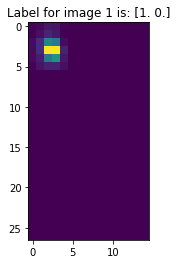

In [5]:
i = 1
plt.imshow(x[i].reshape(27, 15)) #np.sqrt(784) = 28
plt.title("Label for image %i is: %s" % (i, y[i]))

In [6]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
#config = tf.ConfigProto(device_count = {"GPU": 1})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allow_growth=True
config.gpu_options.allocator_type = 'BFC'

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.4

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [7]:
loadpath = "./ModelSnapshots/CNN-33767.h5"
model = tf.keras.models.load_model(loadpath)

In [8]:
%%time
lst = []
batch = 100
for i in range(0, len(x), batch):
    _x = x[i: i+batch]
    lst.extend(model.predict(_x))

CPU times: user 1min 45s, sys: 12 s, total: 1min 57s
Wall time: 1min 12s


In [9]:
df["InputMethodPred"] = lst
df.InputMethodPred = df.InputMethodPred.apply(lambda x: np.argmax(x))

In [10]:
df = df.groupby(["userID", "TaskID", "VersionID"])[["InputMethodPred", "InputMethod"]].agg(lambda x: x.tolist()).reset_index()

In [11]:
from collections import Counter

In [12]:
df.InputMethod = df.InputMethod.apply(lambda x: Counter(x).most_common()[0][0])
df.InputMethodPred = df.InputMethodPred.apply(lambda x: Counter(x).most_common()[0][0])

In [13]:
df.groupby(["InputMethod", "InputMethodPred"]).count()

userID  TaskID  VersionID
InputMethod InputMethodPred                           
0           0                  4425    4425       4425
            1                   124     124        124
1           0                    83      83         83
            1                  5935    5935       5935

In [14]:
df_train = df[df.userID.isin(train_ids)]
df_test = df[df.userID.isin(test_ids)]

In [15]:
print(sklearn.metrics.confusion_matrix(df_train.InputMethod.values, df_train.InputMethodPred.values, labels=[0, 1]))
cm = sklearn.metrics.confusion_matrix(df_train.InputMethod.values, df_train.InputMethodPred.values, labels=[0, 1], )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
print("Accuray: %.3f" % sklearn.metrics.accuracy_score(df_train.InputMethod.values, df_train.InputMethodPred.values))
print("Recall: %.3f" % metrics.recall_score(df_train.InputMethod.values, df_train.InputMethodPred.values))
print("Precision: %.3f" % metrics.average_precision_score(df_train.InputMethod.values, df_train.InputMethodPred.values))
print("F1-Score: %.3f" % metrics.f1_score(df_train.InputMethod.values, df_train.InputMethodPred.values))
print(sklearn.metrics.classification_report(df_train.InputMethod.values, df_train.InputMethodPred.values, target_names=target_names))

[[3260   82]
 [  47 4274]]
[[0.97546379 0.02453621]
 [0.01087711 0.98912289]]
Accuray: 0.983
Recall: 0.989
Precision: 0.977
F1-Score: 0.985
              precision    recall  f1-score   support

     Knuckle       0.99      0.98      0.98      3342
      Finger       0.98      0.99      0.99      4321

   micro avg       0.98      0.98      0.98      7663
   macro avg       0.98      0.98      0.98      7663
weighted avg       0.98      0.98      0.98      7663



In [16]:
print(sklearn.metrics.confusion_matrix(df_test.InputMethod.values, df_test.InputMethodPred.values, labels=[0, 1]))
cm = sklearn.metrics.confusion_matrix(df_test.InputMethod.values, df_test.InputMethodPred.values, labels=[0, 1], )
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)
print("Accuray: %.3f" % sklearn.metrics.accuracy_score(df_test.InputMethod.values, df_test.InputMethodPred.values))
print("Recall: %.3f" % metrics.recall_score(df_test.InputMethod.values, df_test.InputMethodPred.values))
print("Precision: %.3f" % metrics.average_precision_score(df_test.InputMethod.values, df_test.InputMethodPred.values))
print("F1-Score: %.3f" % metrics.f1_score(df_test.InputMethod.values, df_test.InputMethodPred.values))
print(sklearn.metrics.classification_report(df_test.InputMethod.values, df_test.InputMethodPred.values, target_names=target_names))

[[1165   42]
 [  36 1661]]
[[0.96520298 0.03479702]
 [0.02121391 0.97878609]]
Accuray: 0.973
Recall: 0.979
Precision: 0.967
F1-Score: 0.977
              precision    recall  f1-score   support

     Knuckle       0.97      0.97      0.97      1207
      Finger       0.98      0.98      0.98      1697

   micro avg       0.97      0.97      0.97      2904
   macro avg       0.97      0.97      0.97      2904
weighted avg       0.97      0.97      0.97      2904

